In [1]:
import pandas as pd
import sqlite3


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from IPython.display import clear_output

In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [5]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("./clientes.db")
df = pd.read_sql_query("SELECT * from player", con)

In [6]:
def map_float(x):
    return float(x)
df.head(100)
df["mlt"] = df["mlt"].map(map_float)

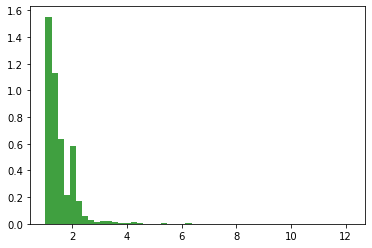

In [7]:
n, bins, patches = plt.hist(df[df["mlt"]  >0]["mlt"], 50, density=True, facecolor='g', alpha=0.75)

In [8]:

df_tempo = pd.read_sql_query("SELECT * from tempo", con)
df_tempo.head()

,id,tempo
0,1,2.99
1,2,20.39
2,3,1.83
3,4,2.5
4,5,1.47


In [9]:
df_tempo["tempo"] = df_tempo["tempo"].map(map_float)

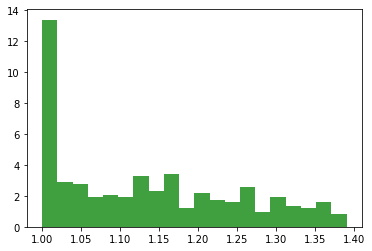

In [10]:
n, bins, patches = plt.hist(df_tempo[df_tempo["tempo"]<1.4]["tempo"], 20, density=True, facecolor='g', alpha=0.75)

In [11]:
len(df_tempo[df_tempo["tempo"] <= 1.5]["tempo"])/len(df_tempo[df_tempo["tempo"] >= 1.5]["tempo"])

0.7537993920972644

In [12]:
len(df_tempo[df_tempo["tempo"] <= 1.4]["tempo"])/len(df_tempo["tempo"])

0.37554585152838427

In [13]:
# 1- 1.4, 1.4-2.1, 2-1

In [14]:
df_tempo["tempo_atra"]  = df_tempo["tempo"].shift(-1)

In [15]:
df_tempo = df_tempo.dropna()
df_tempo
tm_df_tempo = len(df_tempo)

In [16]:
def map_categoria(x):
    r_casa = x >= 1 and x  < 1.4
    r_dinheiro = x >= 1.4 and x <2.3
    r_ganancia = x >= 2.3
    
    if r_casa:
        return "casa"
    elif r_dinheiro:
        return "ganhando"
    elif r_ganancia:
        return "ganancia"
    
    

In [17]:
df_tempo["tempo_c"] = df_tempo["tempo"].map(map_categoria)
df_tempo["tempo_atra_c"] = df_tempo["tempo_atra"].map(map_categoria)

In [18]:
def pega_sequencia(df_tempo, c_preview, c_seguinte):
    r_tempo_c = df_tempo["tempo_c"] == c_preview
    r_tempo_atra_c = df_tempo["tempo_atra_c"] == c_seguinte


    return len(df_tempo[r_tempo_c & r_tempo_atra_c])/len(df_tempo["tempo_c"]) *100
    

In [19]:
d_saida = {}
d_saida["g-ga"] = pega_sequencia(df_tempo,'ganancia','ganancia')
d_saida["g-c"] = pega_sequencia(df_tempo,'ganancia','casa')
d_saida["g-d"] = pega_sequencia(df_tempo,'ganancia','ganhando')

d_saida["c-c"] = pega_sequencia(df_tempo,'casa','casa')
d_saida["c-ga"] = pega_sequencia(df_tempo,'casa','ganancia')
d_saida["c-d"] = pega_sequencia(df_tempo,'casa','ganhando')


d_saida["d-d"] = pega_sequencia(df_tempo,'ganhando','ganhando')
d_saida["d-ga"] = pega_sequencia(df_tempo,'ganhando','ganancia')
d_saida["d-c"] = pega_sequencia(df_tempo,'ganhando','casa')


print(5*"***--")
print("***--GANANCIA")
print(f"ganancia --> ganancia {d_saida['g-ga']}%")
print(f"ganancia --> casa {d_saida['g-c']}%")
print(f"ganancia --> ganhando {d_saida['g-d']}%")
print(5*"***--")


print("***--CASA")
print(f"casa --> casa {d_saida['c-c']}%")
print(f"casa --> ganhando {d_saida['c-d']}%")
print(f"casa --> ganancia {d_saida['g-ga']}%")
print(5*"***--")

print("***--GANHANDO")
print(f"ganhando --> ganhando {d_saida['d-d']}%")
print(f"ganhando --> casa {d_saida['d-ga']}%")
print(f"ganhando --> ganancia {d_saida['d-c']}%")
print(5*"***--")


***--***--***--***--***--
***--GANANCIA
ganancia --> ganancia 15.996503496503497%
ganancia --> casa 14.160839160839162%
ganancia --> ganhando 9.527972027972027%
***--***--***--***--***--
***--CASA
casa --> casa 12.5%
casa --> ganhando 8.916083916083917%
casa --> ganancia 15.996503496503497%
***--***--***--***--***--
***--GANHANDO
ganhando --> ganhando 5.1573426573426575%
ganhando --> casa 8.216783216783217%
ganhando --> ganancia 10.13986013986014%
***--***--***--***--***--


In [20]:
print(f"ganancia {(d_saida['g-ga']+ d_saida['g-d'])/(d_saida['g-ga']+ d_saida['g-c'] + d_saida['g-d'])}")
print(f'casa {(d_saida["c-ga"]+ d_saida["c-d"])/(d_saida["c-ga"]+ d_saida["c-c"] + d_saida["c-d"])}')
print(f'dinheiro {(d_saida["d-ga"]+ d_saida["d-d"])/(d_saida["d-ga"]+ d_saida["d-c"] + d_saida["d-d"])}')


ganancia 0.6431718061674008
casa 0.6603325415676958
dinheiro 0.5687732342007434


# Aqui começa o testador de estrategias

In [21]:
import time

In [22]:
def get_last_resultado():
    query ="""
    SELECT * 
        FROM    tempo
        WHERE   id = (SELECT MAX(id)  FROM tempo);
    """
    # con = sqlite3.connect("./clientes.db")
    cur = con.cursor()
    cur.execute(query)

    rows = cur.fetchall()
    return float(rows[0][1])

# for row in rows:
#     print(row)

In [23]:
montante_inicial = 200
qnt_aposta = 3
lis_montante = []

In [24]:
# antiga
# def estrategia(x):
#     categoria = map_categoria(x)
#     r_casa = categoria == "casa"
#     r_dinheiro = categoria == "ganhando"
#     r_ganancia = categoria == "ganancia"

#     if r_casa:
#         return 1.6 + np.random.uniform(-2,2)*0.1
#     if  r_ganancia:
#         return 1.6 + np.random.uniform(-2,2)*0.1
#     elif r_dinheiro:
#         return 0
#     else:
#         return 0

In [25]:
class estrategia_mock():
    def __init__(self, montante_inicial, estrategia, nome, qnt_aposta=3):
        self.montante_inicial= montante_inicial
        self.montante_atualizado = montante_inicial
        self.estrategia = estrategia
        self.qnt_aposta = qnt_aposta
        self.guarda_produtividade = []
        self.nome = nome
        
    def atualiza_montante(self, novo_valor_tempo):
#         self.last_aposta = novo_valor_tempo
        if novo_valor_tempo > self.t_aposta:
            self.montante_atualizado = self.montante_atualizado + self.qnt_aposta * self.t_aposta
        else:
            self.montante_atualizado  = self.montante_atualizado  - self.qnt_aposta
        self.guarda_produtividade.append(self.montante_atualizado - self.montante_inicial)
    
    def atualiza_imagem_ganhos(self):
        plt.plot(self.guarda_produtividade, label=self.nome)

    
    def faz_aposta(self, valor_tempo_passado, i=0):
        self.t_aposta = self.estrategia(valor_tempo_passado)
        printmd(f"A {self.nome}, apostou o valor de **{self.t_aposta}x**, tem um montante de {self.montante_atualizado}TC na i:{i}; t ultima {valor_tempo_passado}x")

        return self.t_aposta

In [26]:
# def map_categoria(x):
#     r_casa = x >= 1 and x  < 1.4
#     r_dinheiro = x >= 1.4 and x <2.3
#     r_ganancia = x >= 2.3
    
#     if r_casa:
#         return "casa"
#     elif r_dinheiro:
#         return "ganhando"
#     elif r_ganancia:
#         return "ganancia"
    

In [27]:
def estrategia_v0(x):
    def map_categoria(x):
        r_casa = x >= 1 and x  < 1.4
        r_dinheiro = x >= 1.4 and x <2.3
        r_ganancia = x >= 2.3

        if r_casa:
            return "casa"
        elif r_dinheiro:
            return "ganhando"
        elif r_ganancia:
            return "ganancia"
        
    categoria = map_categoria(x)
    r_casa = categoria == "casa"
    r_dinheiro = categoria == "ganhando"
    r_ganancia = categoria == "ganancia"

    if r_casa:
        return 1.3 + np.random.uniform(0,3)*0.1
    if  r_ganancia:
        return 1.6 + np.random.uniform(0,4)*0.1
    elif r_dinheiro:
        return 0
    else:
        return 0

In [28]:
def estrategia_v1(x):
    def map_categoria(x):
        r_casa = x >= 1 and x  < 1.4
        r_dinheiro = x >= 1.4 and x <2.3
        r_ganancia = x >= 2.3

        if r_casa:
            return "casa"
        elif r_dinheiro:
            return "ganhando"
        elif r_ganancia:
            return "ganancia"
    
    categoria = map_categoria(x)
    r_casa = categoria == "casa"
    r_dinheiro = categoria == "ganhando"
    r_ganancia = categoria == "ganancia"

    if r_casa:
        return 1.3 + np.random.uniform(0,3)*0.1
    if  r_ganancia:
        return 1.6 + np.random.uniform(0,4)*0.1
    elif r_dinheiro:
        return 0
    else:
        return 0

In [29]:
def estrategia_v2(x):
    def map_categoria(x):
        r_casa = x >= 1 and x  < 1.4
        r_dinheiro = x >= 1.4 and x <2.3
        r_ganancia = x >= 2.3

        if r_casa:
            return "casa"
        elif r_dinheiro:
            return "ganhando"
        elif r_ganancia:
            return "ganancia"
    
    categoria = map_categoria(x)
    r_casa = categoria == "casa"
    r_dinheiro = categoria == "ganhando"
    r_ganancia = categoria == "ganancia"

    if r_casa:
        return 1.6 + np.random.uniform(0,4)*0.1
    if  r_ganancia:
        return 1.6 + np.random.uniform(0,4)*0.1
    elif r_dinheiro:
        return 0
    else:
        return 0

In [30]:
def estrategia_v3(x):
    categoria = map_categoria(x)
    r_casa = categoria == "casa"
    r_dinheiro = categoria == "ganhando"
    r_ganancia = categoria == "ganancia"

    if r_casa:
        return 0 #1.1 + np.random.uniform(-1,3)*0.1
    if  r_ganancia:
        return 2 + np.random.uniform(0,4)*0.1
    elif r_dinheiro:
        return 0

In [31]:
# e0 = estrategia_mock(200, estrategia_v0, "estrategia_v0")
e1 = estrategia_mock(60, estrategia_v1, "estrategia_v1")
# e2 = estrategia_mock(200, estrategia_v2, "estrategia_v2")
# e3 = estrategia_mock(200, estrategia_v3, "estrategia_v3")

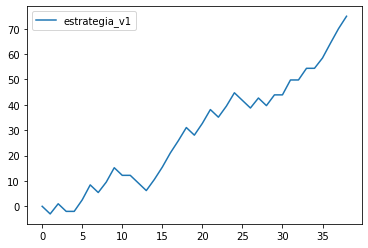

A estrategia_v1, apostou o valor de **1.957952986439813x**, tem um montante de 134.91325833076985TC na i:39; t ultima 20.12x

KeyboardInterrupt: 

In [32]:
lista_estrategia = [e1]
last_t_valor = get_last_resultado()

for i in range(300):
    r_valor_novo_t = True
    
    # criando novas apostas
    for estrategia_c in lista_estrategia:
        estrategia_c.faz_aposta(last_t_valor,i)
    
    while(r_valor_novo_t):
        time.sleep(0.28)
        novo_t_valor = get_last_resultado()
        r_veio_diferente = novo_t_valor != last_t_valor
        if r_veio_diferente:
            r_valor_novo_t = False
            last_t_valor = novo_t_valor

            #atualizando
            for estrategia_c in lista_estrategia:
                estrategia_c.atualiza_montante(novo_t_valor)
                    
            clear_output(wait=True)
            for estrategia_c in lista_estrategia:
                estrategia_c.atualiza_imagem_ganhos()
            
            plt.legend()
            plt.show()
                
                
                
            

In [ ]:
# last_aposta = get_last_resultado()
# r_valor_while = True
# for i in range(150):
#     r_valor_while = True
#     t_aposta = estrategia(last_aposta)
#     print(f"{i} - apostou o valor de {t_aposta}, o tempo da ultima {last_aposta}, tendo um montante de {montante_inicial} ")
# #     print(last_aposta)
    
   
#     while(r_valor_while):
#         time.sleep(0.3)
        
#         novo_valor = get_last_resultado()
#         r_novo_valor = novo_valor != last_aposta
# #         print(r_novo_valor)
#         if r_novo_valor:
#             r_valor_while = False
#             last_aposta = novo_valor

#             if novo_valor > t_aposta:
#                 montante_inicial = montante_inicial + qnt_aposta * t_aposta
#             else:
#                 montante_inicial = montante_inicial - qnt_aposta
#             lis_montante.append(montante_inicial - 200)
#             clear_output(wait=True)
#             plt.plot(lis_montante)
#             plt.show()
# #             print(montante_inicial)

